<a href="https://colab.research.google.com/github/fionaa0-0/NSDC_WINTER26_CHOCOLATE/blob/main/Another_copy_of_Cleaned_Sharks_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

TypeError: 'NoneType' object is not subscriptable

In [ ]:
import pandas as pd
data = pd.read_csv('attacks.csv', encoding='latin-1')
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'attacks.csv'

# New Section

In [ ]:
data.info()
#25723 entries
#only around 6000 are non null entries so around 20000 may be null, missing values, need to convert object to actual values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Case Number  5399 non-null   object
 1   Date         5400 non-null   object
 2   Year         5400 non-null   int64 
 3   Type         5400 non-null   object
 4   Country      5400 non-null   object
 5   Area         5400 non-null   object
 6   Location     5400 non-null   object
 7   Activity     5398 non-null   object
 8   Sex          5400 non-null   object
 9   Age          5400 non-null   int64 
 10  Injury       5400 non-null   object
 11  Fatal (Y/N)  5400 non-null   object
dtypes: int64(2), object(10)
memory usage: 506.4+ KB


In [ ]:
#Removing empty, redundant, and irrelevant columns.
data = data.drop(columns=['href formula', 'href', 'Unnamed: 22', 'Unnamed: 23', 'Time', 'pdf', 'Investigator or Source', 'Case Number.1','Species ', 'Case Number.2', 'original order'])

KeyError: "['href formula', 'href', 'Unnamed: 22', 'Unnamed: 23', 'Time', 'pdf', 'Investigator or Source', 'Case Number.1', 'Species ', 'Case Number.2', 'original order'] not found in axis"

In [ ]:
if 'Fatal (Y/N)' in data.columns:
    data['Fatal (Y/N)'] = data['Fatal (Y/N)'].fillna('Unknown')

if 'Name' in data.columns:
    data = data.drop(columns=['Name'])

if 'Age' in data.columns:
    data['Age'] = pd.to_numeric(data['Age'], errors='coerce')
    mean_age = int(data['Age'].mean(skipna=True))
    data['Age'] = data['Age'].fillna(mean_age).astype(int)

if 'Case Number' in data.columns:
    data['Case Number'] = data['Case Number'].astype(str).str.replace(r'\.0+$', '', regex=True)
    data['Case Number'] = data['Case Number'].str.strip()

sex_cols = [col for col in data.columns if 'Sex' in col]
for col in sex_cols:
    mode_val = data[col].mode()[0]
    data[col] = data[col].fillna(mode_val)

data = data.drop_duplicates()

if 'Year' in data.columns:
    data = data[pd.to_numeric(data['Year'], errors='coerce') >= 1900]

if 'Type' in data.columns:
    data['Type'] = data['Type'].fillna('Unknown')
    data["Type"] = data["Type"].replace("Invalid", "Unknown")

if 'Activity' in data.columns:
    data['Activity'] = data['Activity'].fillna('Unknown')

if 'Injury' in data.columns:
    data['Injury'] = data['Injury'].fillna('Unknown')

if 'Date' in data.columns:
    data['Date'] = data['Date'].str.replace('reported', '', case=False, regex=True).str.strip()

if 'Area' in data.columns:
   data = data[data['Area'].astype(str).str.match(r'^[A-Za-z\s\-\']+$', na=False)]
   print("Shape after filtering Area:", data.shape)
   display(data.head())
else:
   print("'Area' column not found in the DataFrame.")


Shape after filtering Area: (5102, 12)


,Case Number,Date,Year,Type,Country,Area,Location,Activity,Sex,Age,Injury,Fatal (Y/N)
0,2018.06.25,Jun-2018,2018,Boating,Usa,California,"Oceanside, San Diego County",Paddling,F,57,"No injury to occupant, outrigger canoe and pad...",N
1,2018.06.18,Jun-2018,2018,Unprovoked,Usa,Georgia,"St. Simon Island, Glynn County",Standing,F,11,Minor injury to left thigh,N
2,2018.06.09,Jun-2018,2018,Unknown,Usa,Hawaii,"Habush, Oahu",Surfing,M,48,Injury to left lower leg from surfboard skeg,N
3,2018.06.08,Jun-2018,2018,Unprovoked,Australia,New South Wales,Arrawarra Headland,Surfing,M,27,Minor injury to lower leg,N
4,2018.06.04,Jun-2018,2018,Provoked,Mexico,Colima,La Ticla,Free Diving,M,27,Lacerations to leg & hand shark PROVOKED INCIDENT,N


In [ ]:
import pandas as pd

#to split data and remove the dya value from dates that have them
mask_with_day = data['Date'].str.match(r'^\d{2}-[A-Za-z]{3}-\d{4}$')

# Split data
data_with_day = data[mask_with_day]
data_without_day = data[~mask_with_day]

data.loc[mask_with_day, 'Date'] = data.loc[mask_with_day, 'Date'].str.replace(r'^\d{2}-', '', regex=True)

#For dates without month keep for now, but remove during seasonal analysis.

In [ ]:
from geopy.geocoders import Nominatim
import time

geolocator = Nominatim(user_agent="my_geocoder")

def get_state(location):
    try:
        geo = geolocator.geocode(location, addressdetails=True, timeout=10)
        if geo and 'address' in geo.raw:
            return geo.raw['address'].get('state')
    except Exception as e:
        print(f"Error for {location}: {e}")
        return None

In [ ]:
for i, row in data[data['Area'].isnull()].iterrows():
    state = get_state(row['Location'])
    if state:
        data.at[i, 'Area'] = state
    time.sleep(1)

In [ ]:
data = data.dropna(subset=['Country'])

In [ ]:
data['Area'] = data.apply(
    lambda row: f"Unknown, {row['Country']}" if pd.isnull(row['Area']) else row['Area'],
    axis=1
)
data['Area'] = data['Area'].str.strip().str.title()

In [ ]:
data['Location'] = data.apply(
    lambda row: f"Unknown, {row['Area']}" if pd.isnull(row['Location']) else row['Location'],
    axis=1
)
data['Location'] = data['Location'].str.strip().str.title()

In [ ]:
cols_to_fix = ["Country", "Type", "Activity"]
for col in cols_to_fix:
    data[col] = data[col].str.strip().str.title()

In [ ]:
data["Year"] = pd.to_numeric(data["Year"], errors="coerce").astype("Int64")

In [ ]:
data['Date'] = data['Date'].str.replace('reported', '', regex=False).str.strip()

In [ ]:
data.isnull().sum()

,0
Case Number,0
Date,0
Year,0
Type,0
Country,0
Area,0
Location,0
Activity,0
Sex,0
Age,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5102 entries, 0 to 5399
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Case Number  5102 non-null   object
 1   Date         5102 non-null   object
 2   Year         5102 non-null   Int64 
 3   Type         5102 non-null   object
 4   Country      5102 non-null   object
 5   Area         5102 non-null   object
 6   Location     5102 non-null   object
 7   Activity     5102 non-null   object
 8   Sex          5102 non-null   object
 9   Age          5102 non-null   int64 
 10  Injury       5102 non-null   object
 11  Fatal (Y/N)  5102 non-null   object
dtypes: Int64(1), int64(1), object(10)
memory usage: 523.2+ KB


In [ ]:
data.to_csv('cleaned_dataset.csv', index=False) #To download the dataset

In [ ]:
import os
print(os.getcwd()) #To see where the dataset is downloaded at

/content


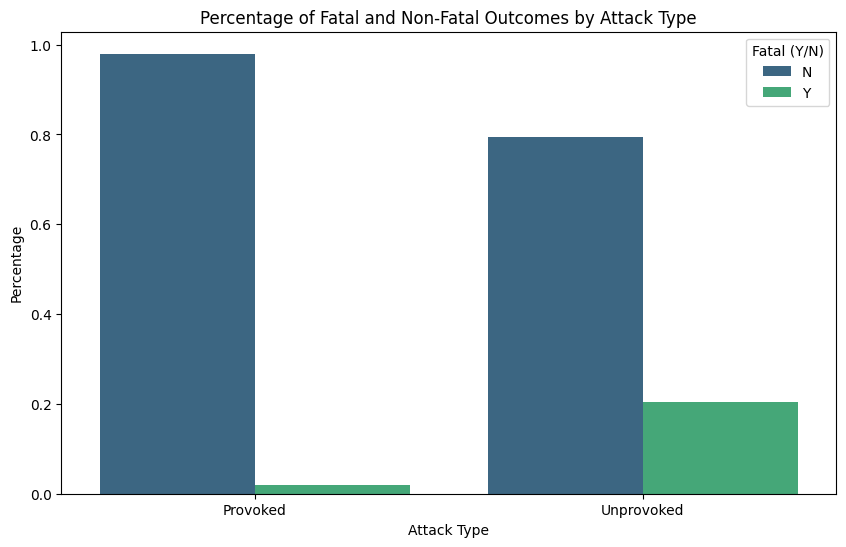

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter data for 'Provoked' and 'Unprovoked' attack types and 'Fatal (Y/N)' is 'Y' or 'N'
filtered_data = data[data['Type'].isin(['Provoked', 'Unprovoked']) & data['Fatal (Y/N)'].isin(['Y', 'N'])]

# Group by Type and Fatal (Y/N) and count the occurrences
fatal_counts_by_type = filtered_data.groupby(['Type', 'Fatal (Y/N)']).size().reset_index(name='Count')

# Calculate the percentage within each Type
fatal_counts_by_type['Percentage'] = fatal_counts_by_type.groupby('Type')['Count'].transform(lambda x: x / x.sum())

# Create a grouped bar plot with percentages
plt.figure(figsize=(10, 6))
sns.barplot(x='Type', y='Percentage', hue='Fatal (Y/N)', data=fatal_counts_by_type, palette='viridis')
plt.title('Percentage of Fatal and Non-Fatal Outcomes by Attack Type')
plt.xlabel('Attack Type')
plt.ylabel('Percentage')
plt.show()

In [ ]:
# Count attacks per country per year
attacks_by_year = data.groupby(['Country', 'Year']).size().reset_index(name='Count')

NameError: name 'data' is not defined